# Example Predictions of Field–Particle Correlation Signatures

Here, we predict the signatures found in Howes (2017), a kinetic Alfvén wave experiencing Landau damping, as an example and generate relevant dispersion relation plots.

Please open a terminal, navigate to the install directory, compile PLUME (run `make all`), and execute all the cells in this notebook to verify that everything is working correctly.

This notebook and the related libraries serve as wrappers that generate and call input files for PLUME by issuing commands like `os.system('./plume.e *flnm*.in >> outlog')`. One can also use `./plume.e *flnm*.in` to run PLUME directly. The library functions called via `lfpc.*funcname*(*args*)` generate inputs and run PLUME. Functions called via `lp.*funcname*(*args*)` generate plots.

You will need to be able to call a Bash terminal when the library executes commands like `os.system('*command*')`. This is the default behavior for most Jupyter Notebook installations on macOS and likely on Linux as well. Windows will likely require additional setup.

The plotting library is meant to serve as an example for users to modify, as it is not complete.

If things are not behaving as expected, please check the `outlog`, where all PLUME output is saved when using this notebook.

**Please check `outlog` for any warnings that PLUME may generate and write there. These warnings will not be presented here in any form. Using this notebook, one may input parameters that allow the solver to run but violate the assumptions made when deriving the equations used by the solver.**

**Note:** Here, we create a class `plumeinput` that contains input parameters accumulated throughout this notebook. Be sure to run all earlier cells containing `plumeinput.*command*(*arguments*)` before making any `lfpc.*function*(*arguments*)` calls, as the wrapper class may require those parameters.


## Load libraries, and enter parameters

In [1]:
import linfpclib.linfpc as lfpc
import linfpclib.linfpcplot as lp

import os
import numpy as np

In [2]:
#if a change is made to the above libraries, one can either restart the notebook, 
#  or call these functions to load changes in library
import importlib
importlib.reload(lfpc)
importlib.reload(lp)

<module 'linfpclib.linfpcplot' from '/Users/collinbrown/Documents/privatePLUME/PLUME/linfpclib/linfpcplot.py'>

In [3]:
filetag = 'howes2017' #this will be used to name all output files and folders
plumeinput = lfpc.plume_input(filetag)

In [4]:
betap=1
kperp=1.3
kpar=.001 #not specified in paper but when kpar << 1, exact number is not needed as dynamics don't change much in this regime
vtp=1.0E-4
nspec=2
nscan=1
option=1
nroot_max=20
use_map=True
writeOut=True

plumeinput.set_params(betap,kperp,kpar,vtp,nspec,nscan,option,\
                    nroot_max,use_map,writeOut)

In [5]:
#make ions
tauS=1.0
muS=1.0
alphS=1.0
Qs=1.0
Ds=1.0
vvS=0.
plumeinput.make_species(tauS, muS, alphS, Qs, Ds, vvS, spec_n = 1) #be sure to specify species number

No species found, creating first species...


In [6]:
#make elecs
tauS=1
muS=1836
alphS=1.0
Qs=-1.0
Ds=1.0
vvS=0.
plumeinput.make_species(tauS, muS, alphS, Qs, Ds, vvS, spec_n = 2)

Appending species to list. Total species is now  2


In [44]:
#given the fixed above parameters, PLUME solves the dispersion relation for values over the range of omega
#and gamma given below. It initializes a grid (either log spaced or evenly spaced) and does it's best to find 
#all roots in this range. For each grid point, gradient descent is used to try and find a nearby solution.
#Sometimes this results in no found root. Sometimes roots are found outside the sweep range 
#(both close to the range, and very far from it)
loggridw=False #Don't sweep from positive to negative if true! (b/c log(0))
omi=1.0E-05
omf=1.0E-2
gami=-2.0E-03
gamf=-2.0E-6
positive_roots=True
plumeinput.set_maps(loggridw,omi,omf,gami,gamf,positive_roots)

#Finding the correct root can be hard sometimes! Try different grids!
#Also, sometimes roots don't fully converge, so different grids may find the same root but have slightly different values

In [45]:
inputfldr= 'inputs/'+filetag+'/' #folder where all generated input files will be placed
cmd = 'mkdir '+inputfldr
print(cmd)
os.system(cmd) #256 exit code means folder already exits (no need to worry), 0 means it sucessfully made the folder

figuresfldr = 'figures/'+filetag+'/' #folder where figures will be saved as pngs
cmd = 'mkdir '+figuresfldr
print(cmd)
os.system(cmd)

mkdir inputs/howes2017/
mkdir figures/howes2017/


mkdir: inputs/howes2017/: File exists
mkdir: figures/howes2017/: File exists


256

## Find roots

In [46]:
importlib.reload(lp)
roots = lfpc.compute_roots(plumeinput,inputfldr+'roots',filetag)

OVERWRITING OPTION; TODO CHECK THAT plume_input IS CORRECT INSTEAD...
mkdir data/howes2017
./plume.e inputs/howes2017/roots.in >> outlog


mkdir: data/howes2017: File exists


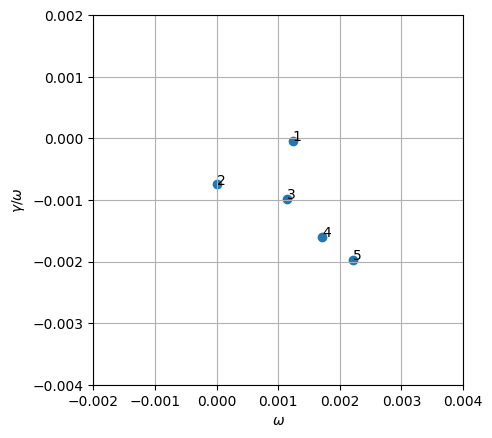

In [50]:
flnm = 'figures/'+filetag+'/'+filetag+'roots.png'
lp.plot_roots(roots,flnm=flnm,xlim=[-0.002,.004],ylim=[-.004,0.002])

## Select root to compute dispersion relation as a function of selected variable and predict damping contribution by mechanisms 
The following block of code will plot the dispersion relation for the root at index 2

In [51]:
roots

array([1.3300e+01+1.0429e+01j, 1.2362e-03-4.4355e-05j,
       3.4468e-14-7.4376e-04j, 1.1473e-03-9.8322e-04j,
       1.7166e-03-1.5983e-03j, 2.2089e-03-1.9704e-03j,
       1.4252e+01+8.9696e+00j])

In [52]:
rootidx = 1
roots[rootidx] #later we show that this is the alfven root

(0.0012362-4.4355e-05j)

In [53]:
importlib.reload(lfpc)
sweepvarkey = 'kperp' #change this value to sweep over other variables
                      #wrapper currently supports kperp, kpar, betap, and vtp sweeps
                      #see readme for all available sweep options
stylenum = 0
sweepmin = .1
sweepmax = 100
root = roots[rootidx]
inputflnm = inputfldr+'sweep'
outputname = 'sweep'
sweep = lfpc.make_sweeps_that_branch_from_params(plumeinput,stylenum,sweepvarkey,sweepmin,sweepmax,root,inputflnm,outputname,outlog='outlog',nsamps=50)

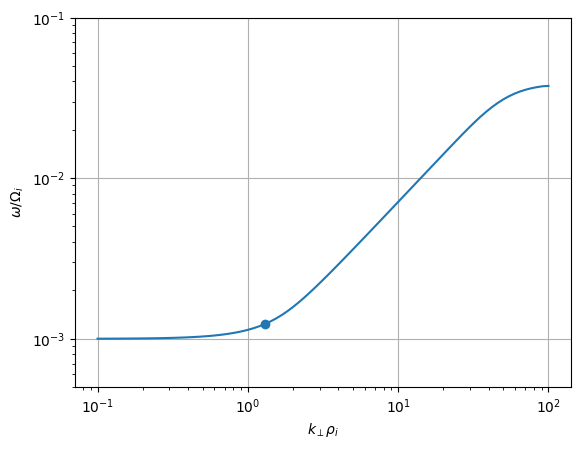

In [60]:
xkey = 'kperp'
ykey = 'w'
xlabel = r"$k_\perp \rho_i$"
ylabel = r"$\omega / \Omega_i$"
ylim = [0.0005,.1]
xlim = []
root = roots[rootidx]

plot_root = True #will plot scatter point x,y = sweep[xkey],sweep['w'] for value at input kperp,kpar,omega. This is the origin of the sweep

flnm = 'figures/'+filetag+'/'+filetag+'disprelkperpw.png'
lp.plot_disp_rel(plumeinput, root, sweep, xkey, ykey, xlabel, ylabel, flnm = flnm, plot_root = plot_root, xlim = xlim, ylim = ylim)

In [61]:
#other keys that can be plotted as a function of sweepvarkey
print(sweep.keys())

dict_keys(['kperp', 'kpar', 'betap', 'vtp', 'w', 'g', 'bxr', 'bxi', 'byr', 'byi', 'bzr', 'bzi', 'exr', 'exi', 'eyr', 'eyi', 'ezr', 'ezi', 'ux1r', 'ux1i', 'uy1r', 'uy1i', 'uz1r', 'uz1i', 'ux2r', 'ux2i', 'uy2r', 'uy2i', 'uz2r', 'uz2i', 'n1r', 'n1i', 'n2r', 'n2i', 'p1', 'p2', 'p1ttd_yy', 'p1ttd_yz', 'p1ld_zy', 'p1ld_zz', 'p1n_eq_0', 'p1cd_n_pm', 'p2ttd_yy', 'p2ttd_yz', 'p2ld_zy', 'p2ld_zz', 'p2n_eq_0', 'p2cd_n_pm', 'p1tau', 'p1mu', 'p1alph', 'p1q', 'p1D', 'p1vv', 'p2tau', 'p2mu', 'p2alph', 'p2q', 'p2D', 'p2vv'])


In [62]:
sweep.keys()

dict_keys(['kperp', 'kpar', 'betap', 'vtp', 'w', 'g', 'bxr', 'bxi', 'byr', 'byi', 'bzr', 'bzi', 'exr', 'exi', 'eyr', 'eyi', 'ezr', 'ezi', 'ux1r', 'ux1i', 'uy1r', 'uy1i', 'uz1r', 'uz1i', 'ux2r', 'ux2i', 'uy2r', 'uy2i', 'uz2r', 'uz2i', 'n1r', 'n1i', 'n2r', 'n2i', 'p1', 'p2', 'p1ttd_yy', 'p1ttd_yz', 'p1ld_zy', 'p1ld_zz', 'p1n_eq_0', 'p1cd_n_pm', 'p2ttd_yy', 'p2ttd_yz', 'p2ld_zy', 'p2ld_zz', 'p2n_eq_0', 'p2cd_n_pm', 'p1tau', 'p1mu', 'p1alph', 'p1q', 'p1D', 'p1vv', 'p2tau', 'p2mu', 'p2alph', 'p2q', 'p2D', 'p2vv'])

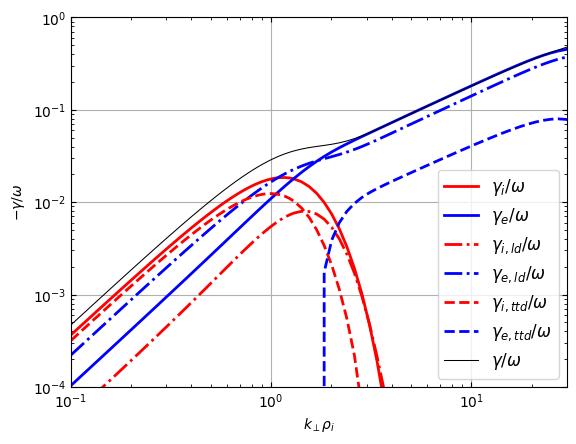

In [63]:
#plot power rate due to different mechanisms/ susc tensor 'splits' 
#INTO the particles in units of gamma/omega (that is gamma/omega = -1 indicates that particles are gaining energy)

xlim = [0.1,30]
ylim = [0.0001,1]
importlib.reload(lfpc)
importlib.reload(lp)

flnm = 'figures/'+filetag+'/'+filetag+'disprelpowers.png'
lp.plot_disp_power_2spec(sweep,flnm=flnm,xlim=xlim,ylim=ylim)

In [64]:
#sweep over species parameters too
sweepvarkey = 'tauS' #change this variable to sweep over other variables
                      #wrapper currently supports kperp, kpar, betap, and vtp sweeps
                      #see readme for all available sweep options
stylenum = 2 #2 to change second species tauS
sweepmin = .1
sweepmax = 100
root = roots[rootidx]
inputflnm = inputfldr+'sweep'
outputname = 'sweep'
sweep = lfpc.make_sweeps_that_branch_from_params(plumeinput,stylenum,sweepvarkey,sweepmin,sweepmax,root,inputflnm,outputname,outlog='outlog',nsamps=50,verbose=False)

In [65]:
sweep.keys()

dict_keys(['kperp', 'kpar', 'betap', 'vtp', 'w', 'g', 'bxr', 'bxi', 'byr', 'byi', 'bzr', 'bzi', 'exr', 'exi', 'eyr', 'eyi', 'ezr', 'ezi', 'ux1r', 'ux1i', 'uy1r', 'uy1i', 'uz1r', 'uz1i', 'ux2r', 'ux2i', 'uy2r', 'uy2i', 'uz2r', 'uz2i', 'n1r', 'n1i', 'n2r', 'n2i', 'p1', 'p2', 'p1ttd_yy', 'p1ttd_yz', 'p1ld_zy', 'p1ld_zz', 'p1n_eq_0', 'p1cd_n_pm', 'p2ttd_yy', 'p2ttd_yz', 'p2ld_zy', 'p2ld_zz', 'p2n_eq_0', 'p2cd_n_pm', 'p1tau', 'p1mu', 'p1alph', 'p1q', 'p1D', 'p1vv', 'p2tau', 'p2mu', 'p2alph', 'p2q', 'p2D', 'p2vv'])

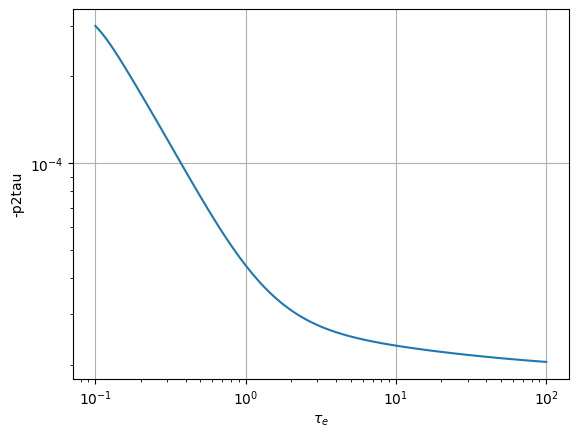

In [66]:
xkey = 'p2tau'
ykey = 'g'
xlabel = r"$\tau_e$"
ylabel = r"p2tau"
ylim = []
xlim = []
root = roots[rootidx]

plot_root = False #will plot scatter point x,y = sweep[xkey],sweep['w'] for value at input kperp,kpar,omega. This is the origin of the sweep

flnm = 'figures/'+filetag+'/'+filetag+'dispreltotpower.png'
lp.plot_disp_rel(plumeinput, root, sweep, xkey, ykey, xlabel, ylabel, flnm=flnm, plot_root = plot_root, xlim = xlim, ylim = ylim)

## Sweep over two variables from selected root

In [67]:
var1key = 'kperp'
var2key = 'kpar'

var1min = 1
var1max = 10
var2min = 1
var2max = 10

stylenum1 = 0
stylenum2 = 0

inputflnm = inputfldr+'2varsweep'
outputname = '2varsweep'

sweep2d = lfpc.branch_2var_scan_from_root(plumeinput,stylenum1,stylenum2,var1key,var1min,var1max,var2key,var2min,var2max,root,inputflnm,outputname,verbose=False,outlog='outlog',nsamps=20)
    

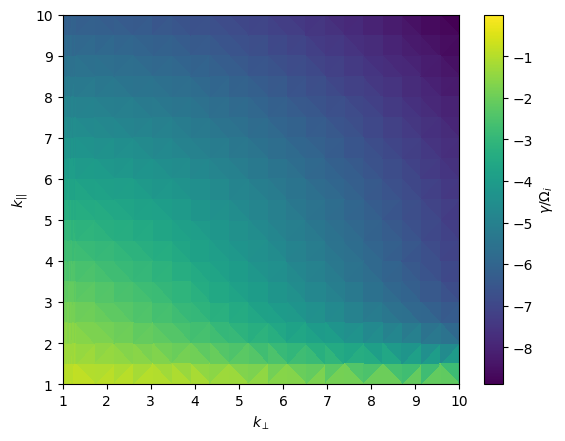

In [68]:
xkey = 'kperp'
ykey = 'kpar'
zkey = 'g'
xlim = [1,10]
ylim = [1,10]
xlabel = r'$k_{\perp}$'
ylabel = r'$k_{||}$'
zlabel = r'$\gamma/\Omega_{i}$'

importlib.reload(lp)
lp.sweep2dplot(sweep2d,xkey,ykey,zkey,xlabel,ylabel,zlabel,xlim=xlim,ylim=ylim,vmin=None,vmax=None)

In [69]:
importlib.reload(lfpc)
importlib.reload(lp)


var1key = 'betap'
var2key = 'alphS'

var1min = 0.5
var1max = 5
var2min = 0.5
var2max = 5

stylenum1 = 0
stylenum2 = 1

inputflnm = inputfldr+'2varsweep'
outputname = '2varsweep'

sweep2d_2 = lfpc.branch_2var_scan_from_root(plumeinput,stylenum1,stylenum2,var1key,var1min,var1max,var2key,var2min,var2max,root,inputflnm,outputname,verbose=False,outlog='outlog',nsamps=20)
    

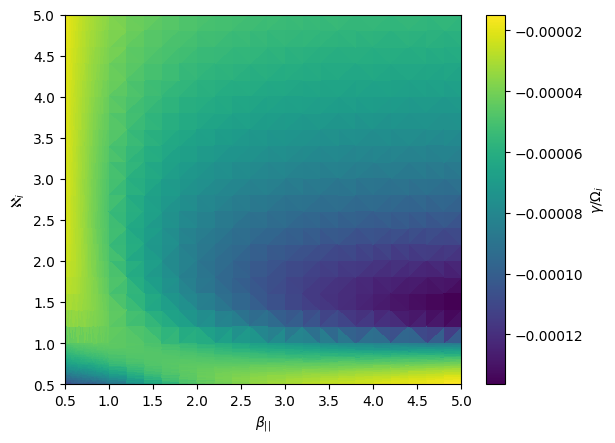

In [70]:
xkey = 'betap'
ykey = 'p1alph'
zkey = 'g'
xlim = [.5,5]
ylim = [.5,5]
xlabel = r'$\beta_{||}$'
ylabel = r'$\aleph_i$' #Tperp,i to Tpar,i ratio
zlabel = r'$\gamma/\Omega_{i}$'

importlib.reload(lp)
lp.sweep2dplot(sweep2d_2,xkey,ykey,zkey,xlabel,ylabel,zlabel,xlim=xlim,ylim=ylim,vmin=None,vmax=None)

## Predict FPC signature of selected root and fs1 in gyro coordinates

The following blocks of code will generate 8 figures in the 'figures' folder of the parallel correlation, perpendicular correlation, and real/imag component of fs1 for both species.

In [71]:
vperpmin = .0
vperpmax = 3
vparmin = -3
vparmax = 3
delv = .15
elecdircontribution = 0. #If equal to 1. 2. or 3., will return contribution to signatures by Eperp1, Eperp2, Epar in isolation. Leave alone if unsure what this means. Note, this relates to the contribution by the individual elements of the susc tensor...
plumeinput.set_fpc(vperpmin,vperpmax,vparmin,vparmax,delv,elecdircontribution=elecdircontribution)

In [72]:
scan_type=0
scan_style=0
swi=0
swf=0
swlog=True
ns=0
nres=1
heating=True #While no sweep is performed here, we need to define these bools, (heating and eigen)
eigen=True
plumeinput.make_scan(scan_type,scan_style,swi,swf,swlog,ns,nres,heating,eigen)

In [73]:
importlib.reload(lfpc)

inputflnm = inputfldr+'fpc'
outputflnm = 'fpc'
cdataflnms = lfpc.compute_fpc_from_root(plumeinput,roots[rootidx],inputflnm,outputflnm)

mkdir data/howes2017
./plume.e inputs/howes2017/fpc.in >> outlog


mkdir: data/howes2017: File exists


In [74]:
#Files produced by above command
print(cdataflnms)

['data/howes2017/fpc.cpar.specie01.mode01', 'data/howes2017/fpc.cperp.specie01.mode01', 'data/howes2017/fpc.df1gyro.real.specie01.mode01', 'data/howes2017/fpc.df1gyro.imag.specie01.mode01', 'data/howes2017/fpc.cpar.specie02.mode01', 'data/howes2017/fpc.cperp.specie02.mode01', 'data/howes2017/fpc.df1gyro.real.specie02.mode01', 'data/howes2017/fpc.df1gyro.imag.specie02.mode01']


In [75]:
iondatacpar = lfpc.loadlinfpccepar(cdataflnms[0])
iondatacperp = lfpc.loadlinfpcceperp(cdataflnms[1])
iondatarfs1 = lfpc.loadlinfpcgyro_dist(cdataflnms[2],cdataflnms[3])
elecdatacpar = lfpc.loadlinfpccepar(cdataflnms[4])
elecdatacperp = lfpc.loadlinfpcceperp(cdataflnms[5])
elecdatarfs1 = lfpc.loadlinfpcgyro_dist(cdataflnms[6],cdataflnms[7])

In [76]:
cmd = 'mkdir figures/'+filetag
print(cmd)
os.system(cmd)

mkdir figures/howes2017


mkdir: figures/howes2017: File exists


256

Saving figure to figures folder!


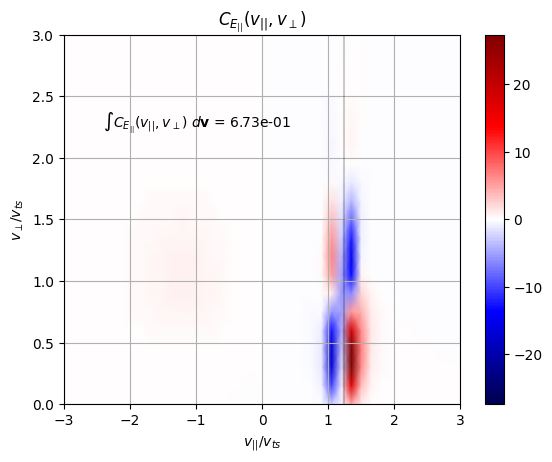

In [77]:
importlib.reload(lp)

lp.plotlinfpc_gyro(iondatacpar,filetag+'/'+filetag+'.png',plotresonant=True) #plotresonant attempts to calculate expected resonant velocity of landau damping and plots a vertical line there
                                                                          #as $\int_{-\infty}^{+\infty} C_E_{||} = j_{||}E_{||}$ it useful to consider this quantity

Saving figure to figures folder!


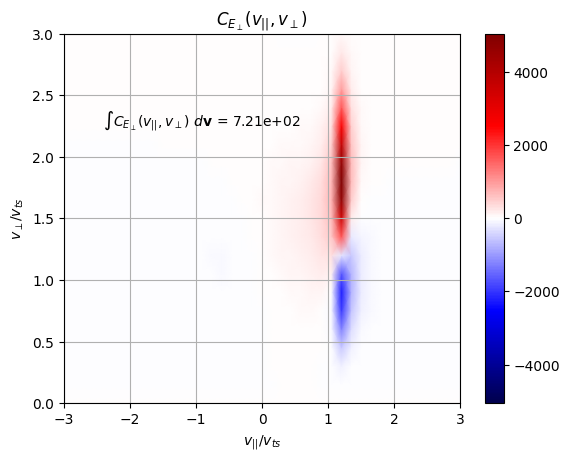

In [78]:
lp.plotlinfpc_gyro(iondatacperp,filetag+'/'+filetag+'cperp.png')

Saving figure to figures folder!


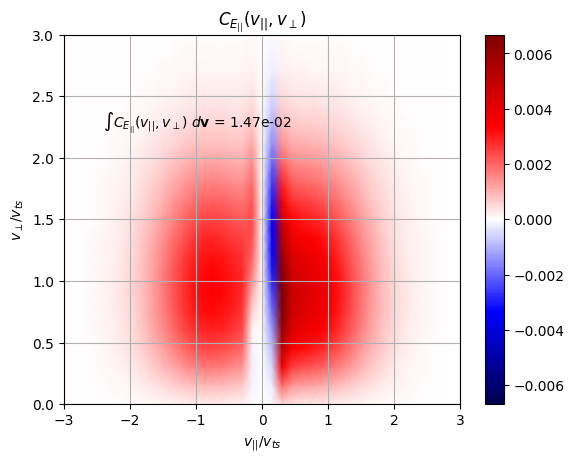

In [79]:
lp.plotlinfpc_gyro(elecdatacpar,filetag+'/'+filetag+'elec.png')

Saving figure to figures folder!


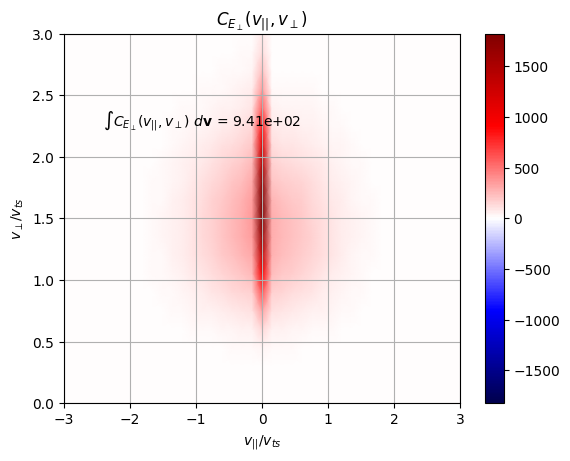

In [80]:
lp.plotlinfpc_gyro(elecdatacperp,filetag+'/'+filetag+'eleccperp.png')

plotting linear scale!
Saving figure to figures folder!


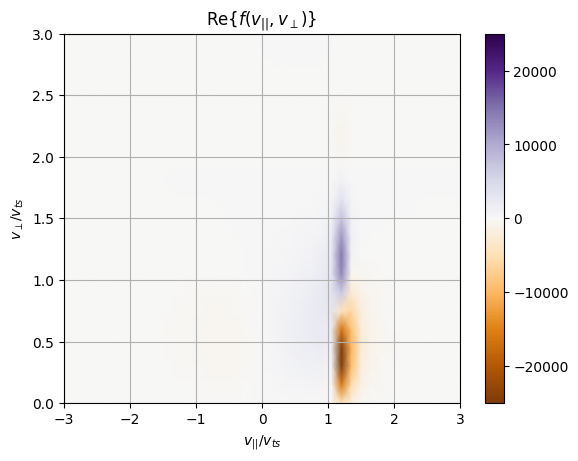

plotting linear scale!
Saving figure to figures folder!


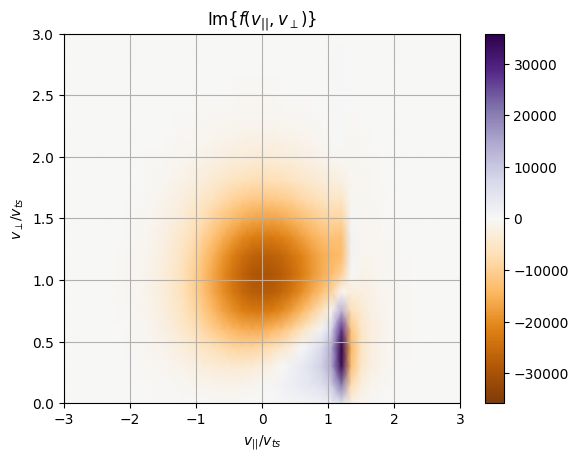

In [81]:
lp.plotlinfpc_gyro_dist(iondatarfs1,filetag+'/'+filetag+'ionrfs1.png','re_f')
lp.plotlinfpc_gyro_dist(iondatarfs1,filetag+'/'+filetag+'ionifs1.png','im_f')

plotting linear scale!
Saving figure to figures folder!


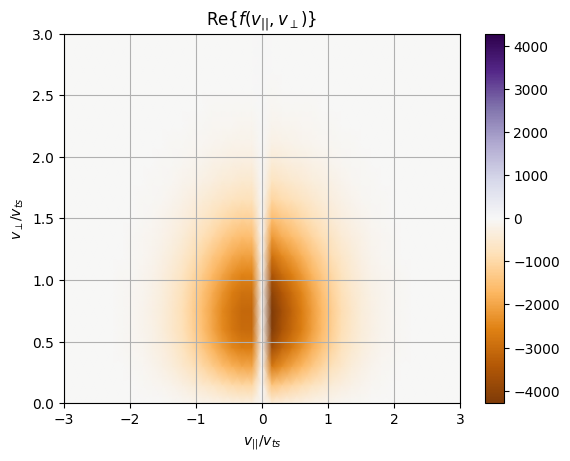

plotting linear scale!
Saving figure to figures folder!


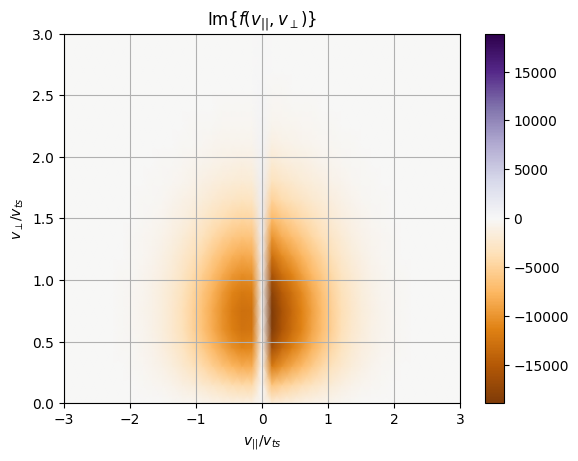

In [82]:
lp.plotlinfpc_gyro_dist(elecdatarfs1,filetag+'/'+filetag+'elecrfs1.png','re_f')
lp.plotlinfpc_gyro_dist(elecdatarfs1,filetag+'/'+filetag+'elecifs1.png','im_f')

# Consider just Eperp2 contribution to jparEpar for ions

In [83]:
vperpmin = .0
vperpmax = 3
vparmin = -3
vparmax = 3
delv = .15
elecdircontribution = 2. #If equal to 1. 2. or 3., will return contribution to signatures by Eperp1, Eperp2, Epar in isolation. 
                         #Leave alone if unsure what this means. Note, this relates to the contribution by the individual elements of the susc tensor...
plumeinput.set_fpc(vperpmin,vperpmax,vparmin,vparmax,delv,elecdircontribution=elecdircontribution)

In [84]:
scan_type=0
scan_style=0
swi=0
swf=0
swlog=True
ns=0
nres=1
heating=True #While no sweep is performed here, we need to define these bools, (heating and eigen)
eigen=True
plumeinput.make_scan(scan_type,scan_style,swi,swf,swlog,ns,nres,heating,eigen)

In [85]:
importlib.reload(lfpc)

inputflnm = inputfldr+'fpc'
outputflnm = 'fpc'
cdataflnms = lfpc.compute_fpc_from_root(plumeinput,roots[rootidx],inputflnm,outputflnm)

mkdir data/howes2017
./plume.e inputs/howes2017/fpc.in >> outlog


mkdir: data/howes2017: File exists


In [86]:
#Files produced by above command
print(cdataflnms)

['data/howes2017/fpc.cpar.specie01.mode01', 'data/howes2017/fpc.cperp.specie01.mode01', 'data/howes2017/fpc.df1gyro.real.specie01.mode01', 'data/howes2017/fpc.df1gyro.imag.specie01.mode01', 'data/howes2017/fpc.cpar.specie02.mode01', 'data/howes2017/fpc.cperp.specie02.mode01', 'data/howes2017/fpc.df1gyro.real.specie02.mode01', 'data/howes2017/fpc.df1gyro.imag.specie02.mode01']


In [87]:
iondatacpar = lfpc.loadlinfpccepar(cdataflnms[0])
iondatacperp = lfpc.loadlinfpcceperp(cdataflnms[1])
iondatarfs1 = lfpc.loadlinfpcgyro_dist(cdataflnms[2],cdataflnms[3])
elecdatacpar = lfpc.loadlinfpccepar(cdataflnms[4])
elecdatacperp = lfpc.loadlinfpcceperp(cdataflnms[5])
elecdatarfs1 = lfpc.loadlinfpcgyro_dist(cdataflnms[6],cdataflnms[7])

In [88]:
cmd = 'mkdir figures/'+filetag
print(cmd)
os.system(cmd)

mkdir figures/howes2017


mkdir: figures/howes2017: File exists


256

Saving figure to figures folder!


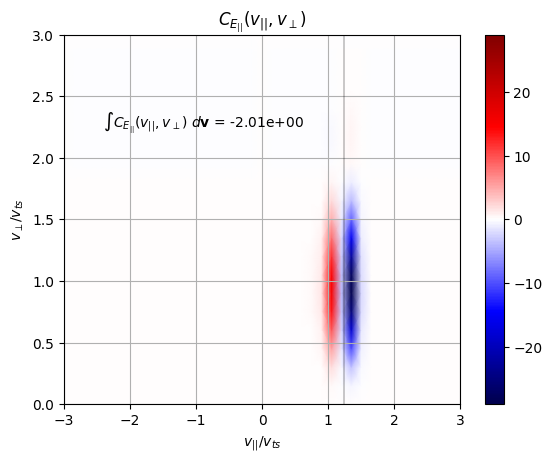

In [89]:
importlib.reload(lp)

lp.plotlinfpc_gyro(iondatacpar,filetag+'/'+filetag+'.png',plotresonant=True) #plotresonant attempts to calculate expected resonant velocity of landau damping and plots a vertical line there
                                                                          #as $\int_{-\infty}^{+\infty} C_E_{||} = j_{||}E_{||}$ it useful to consider this quantity

# Consider just Epar contribution to jparEpar for ions

In [90]:
vperpmin = .0
vperpmax = 3
vparmin = -3
vparmax = 3
delv = .15
elecdircontribution = 3. #If equal to 1. 2. or 3., will return contribution to signatures by Eperp1, Eperp2, Epar in isolation. 
                         #Leave alone if unsure what this means. Note, this relates to the contribution by the individual elements of the susc tensor...
plumeinput.set_fpc(vperpmin,vperpmax,vparmin,vparmax,delv,elecdircontribution=elecdircontribution)

In [91]:
scan_type=0
scan_style=0
swi=0
swf=0
swlog=True
ns=0
nres=1
heating=True #While no sweep is performed here, we need to define these bools, (heating and eigen)
eigen=True
plumeinput.make_scan(scan_type,scan_style,swi,swf,swlog,ns,nres,heating,eigen)

In [92]:
importlib.reload(lfpc)

inputflnm = inputfldr+'fpc'
outputflnm = 'fpc'
cdataflnms = lfpc.compute_fpc_from_root(plumeinput,roots[rootidx],inputflnm,outputflnm)

mkdir data/howes2017
./plume.e inputs/howes2017/fpc.in >> outlog


mkdir: data/howes2017: File exists


In [93]:
#Files produced by above command
print(cdataflnms)

['data/howes2017/fpc.cpar.specie01.mode01', 'data/howes2017/fpc.cperp.specie01.mode01', 'data/howes2017/fpc.df1gyro.real.specie01.mode01', 'data/howes2017/fpc.df1gyro.imag.specie01.mode01', 'data/howes2017/fpc.cpar.specie02.mode01', 'data/howes2017/fpc.cperp.specie02.mode01', 'data/howes2017/fpc.df1gyro.real.specie02.mode01', 'data/howes2017/fpc.df1gyro.imag.specie02.mode01']


In [94]:
iondatacpar = lfpc.loadlinfpccepar(cdataflnms[0])
iondatacperp = lfpc.loadlinfpcceperp(cdataflnms[1])
iondatarfs1 = lfpc.loadlinfpcgyro_dist(cdataflnms[2],cdataflnms[3])
elecdatacpar = lfpc.loadlinfpccepar(cdataflnms[4])
elecdatacperp = lfpc.loadlinfpcceperp(cdataflnms[5])
elecdatarfs1 = lfpc.loadlinfpcgyro_dist(cdataflnms[6],cdataflnms[7])

In [95]:
cmd = 'mkdir figures/'+filetag
print(cmd)
os.system(cmd)

mkdir figures/howes2017


mkdir: figures/howes2017: File exists


256

Saving figure to figures folder!


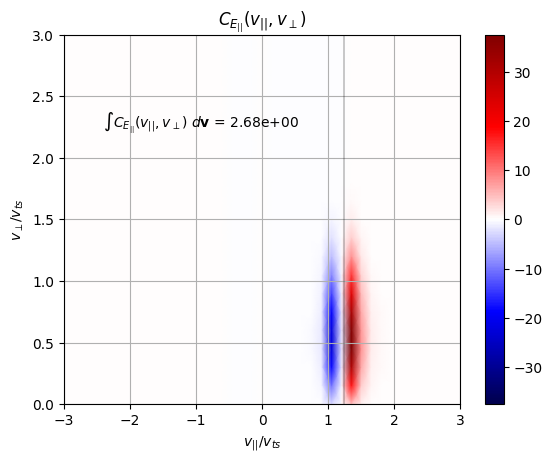

In [96]:
importlib.reload(lp)

lp.plotlinfpc_gyro(iondatacpar,filetag+'/'+filetag+'.png',plotresonant=True) #plotresonant attempts to calculate expected resonant velocity of landau damping and plots a vertical line there
                                                                          #as $\int_{-\infty}^{+\infty} C_E_{||} = j_{||}E_{||}$ it useful to consider this quantity

## Predict FPC signature of selected root and fs1 in cartesian coordinates

mkdir data/howes2017
./plume.e inputs/howes2017/fpc.in >> outlog


mkdir: data/howes2017: File exists


Reading:  data/howes2017/fpc.cparcart.specie01.mode01


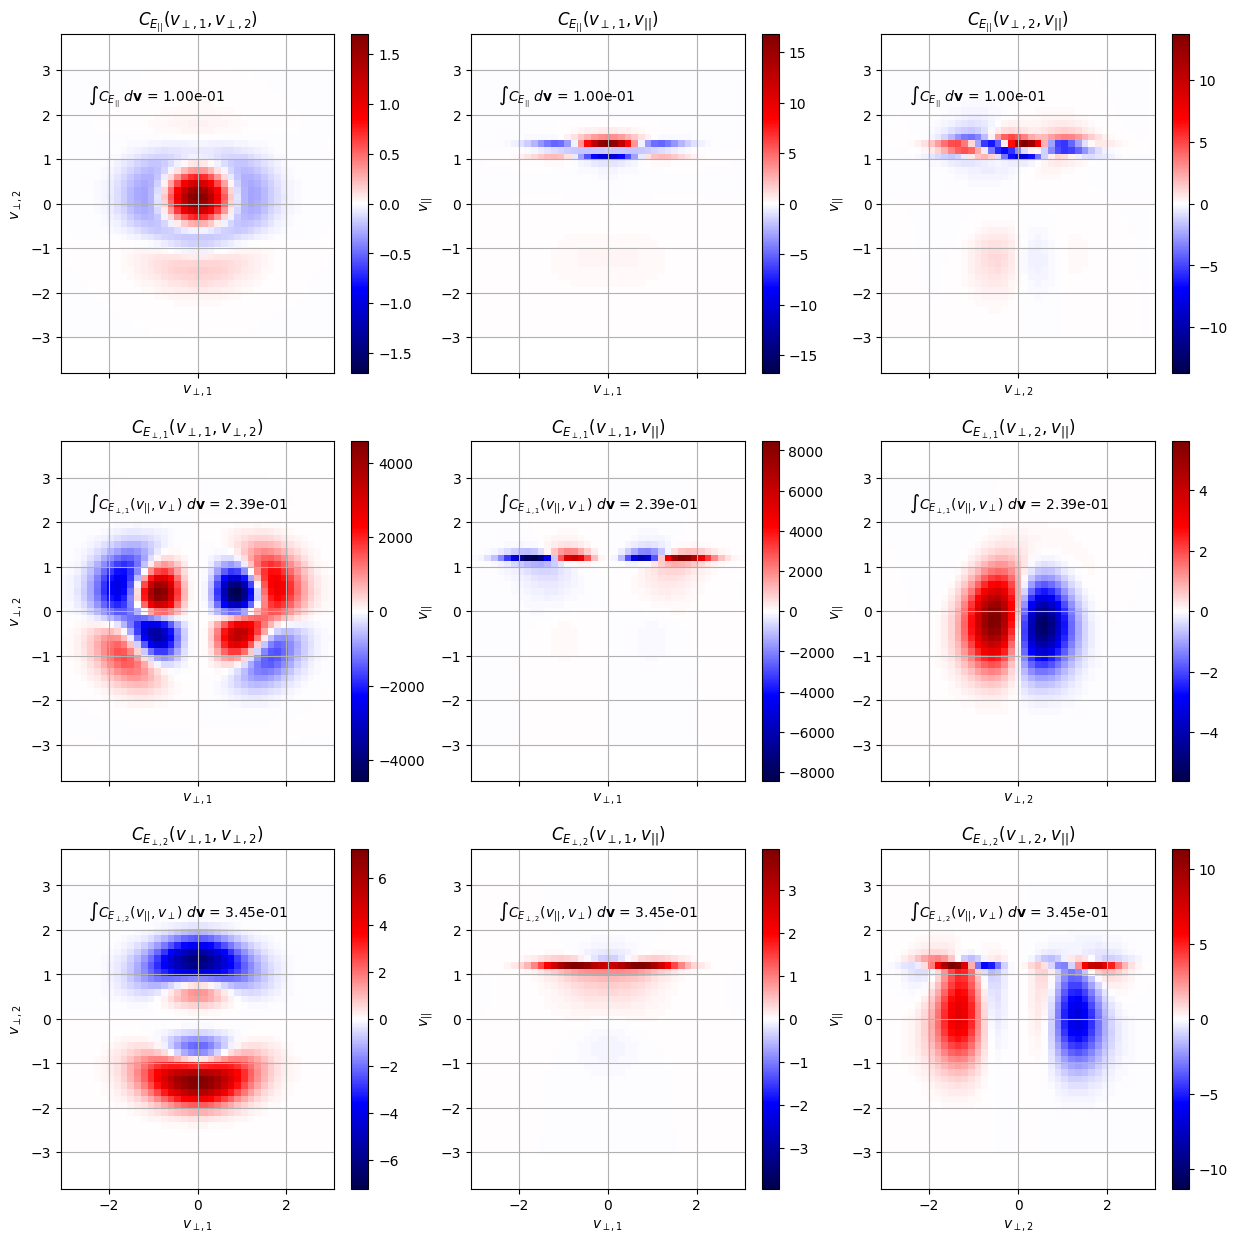

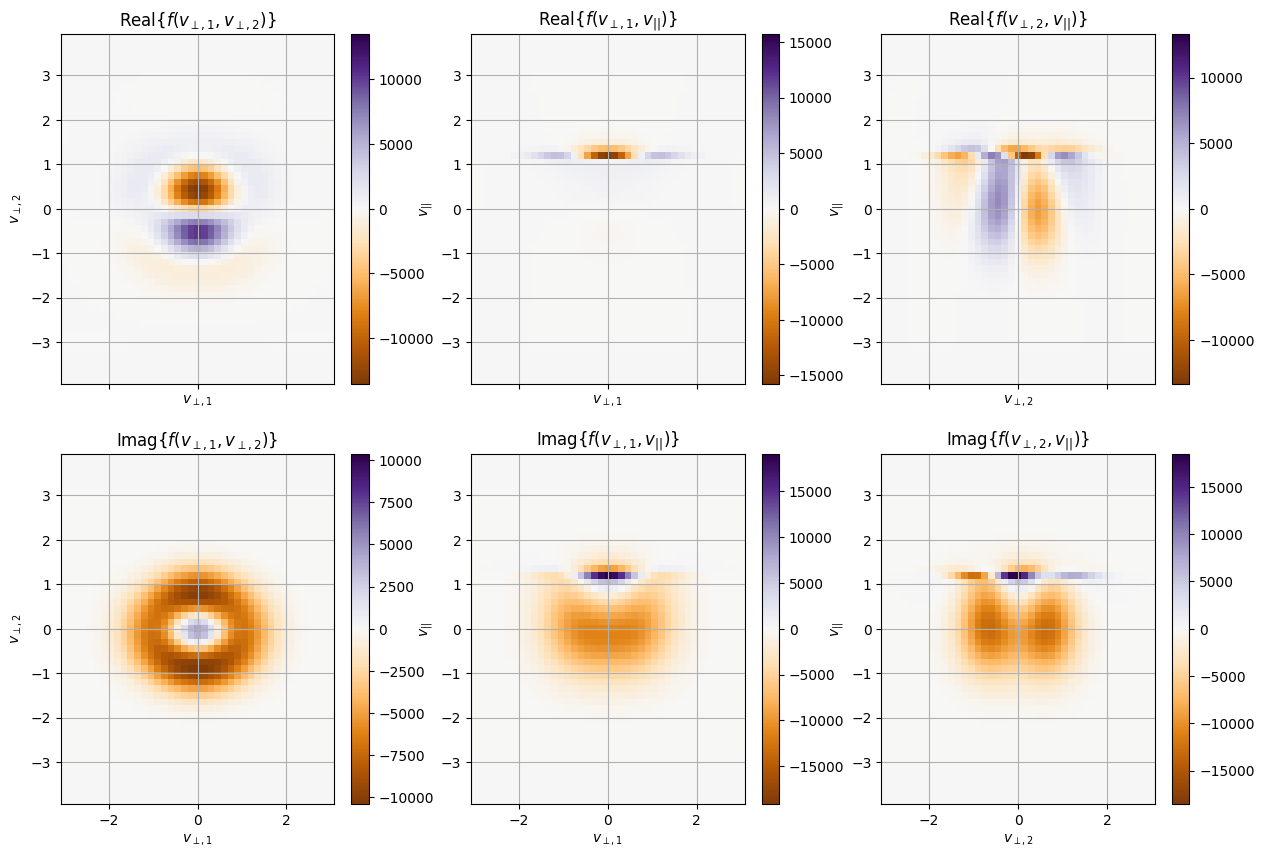

Reading:  data/howes2017/fpc.cparcart.specie02.mode01


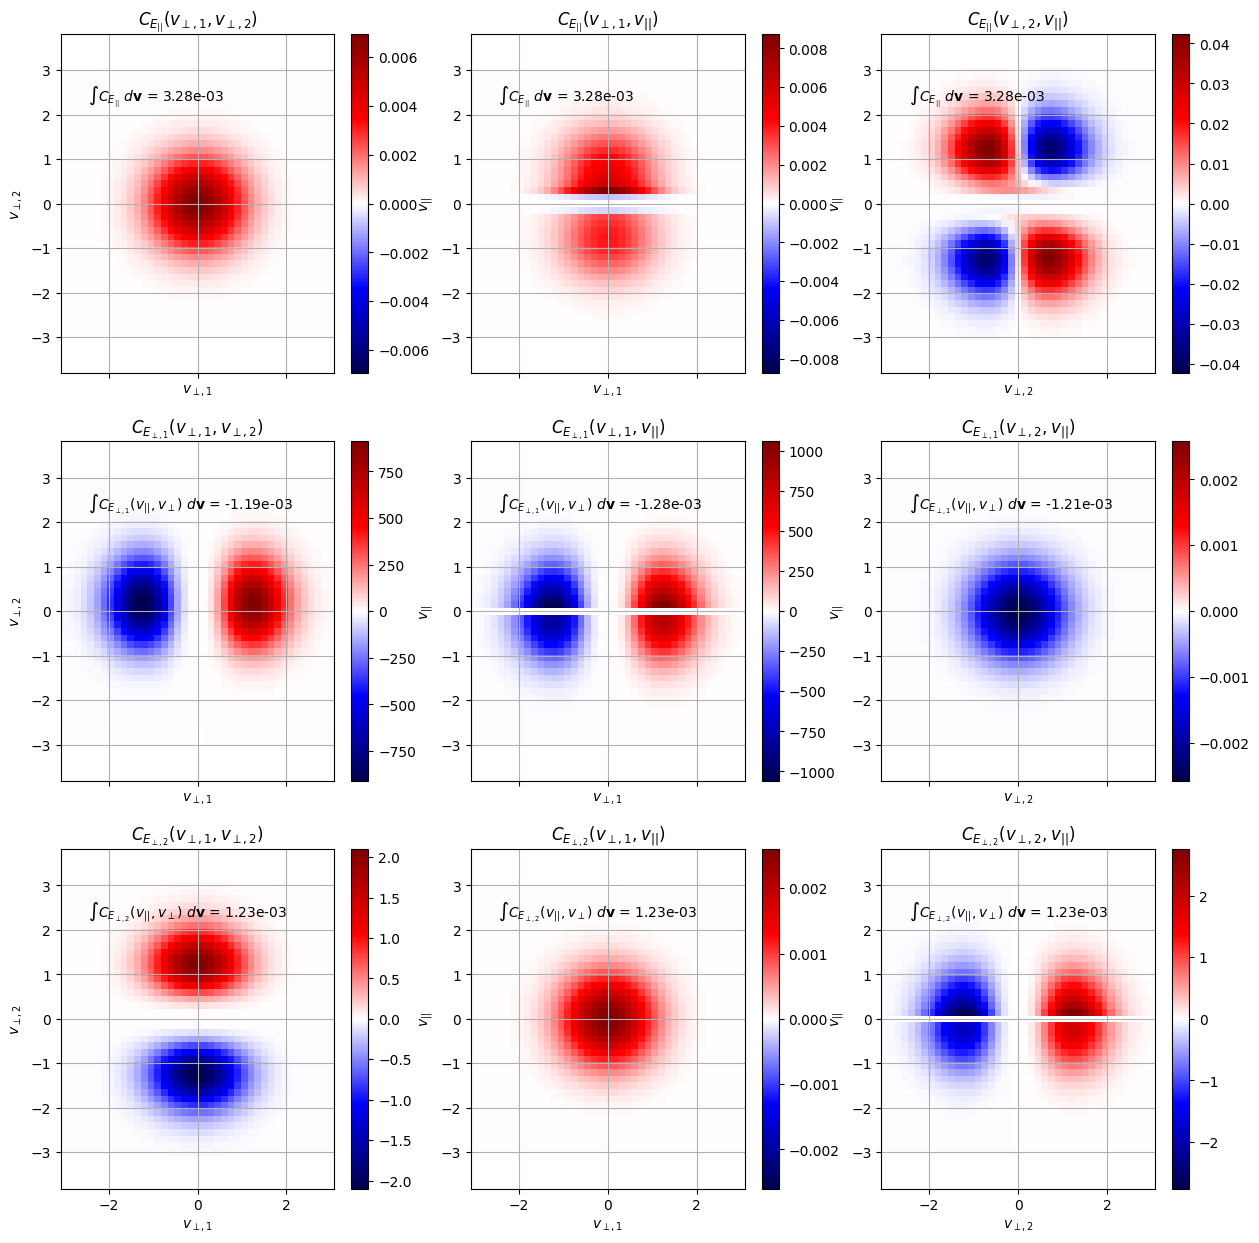

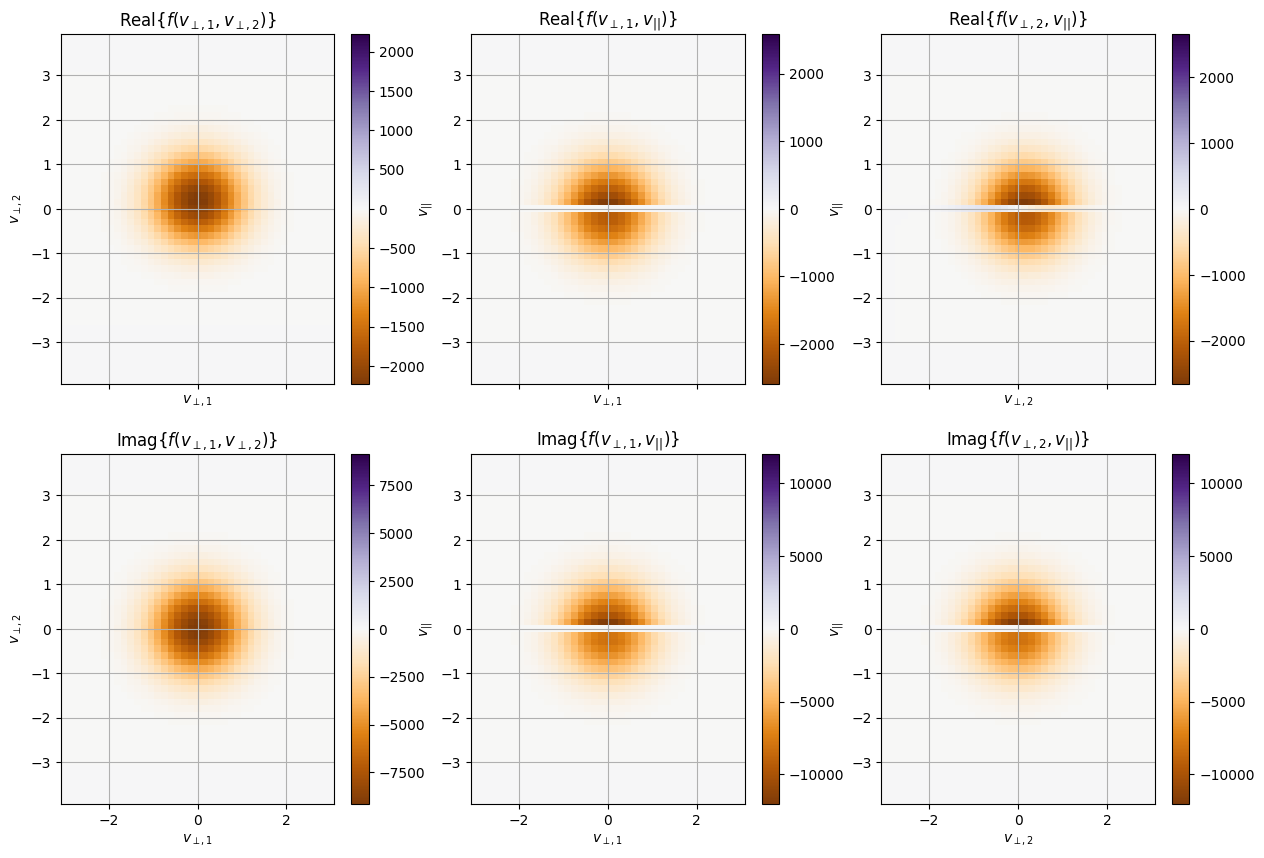

In [97]:
vperpmin = .0
vperpmax = 3 
vparmin = -3
vparmax = 3
vxmin = -3
vymin = -3
vzmin = -3
vxmax = 3
vymax = 3
vzmax = 3
delv = .15
plumeinput.set_fpc(delv=delv,vxmin=vxmin,vxmax=vxmax,vymin=vymin,vymax=vymax,vzmin=vzmin,vzmax=vzmax)


#if a change is made to the above libraries, one can either restart the notebook, 
#  or call these functions to load changes in library
import importlib
importlib.reload(lfpc)
importlib.reload(lp)

inputflnm = inputfldr+'fpc'
outputflnm = 'fpc'
cdataflnms = lfpc.compute_fpc_from_root(plumeinput,roots[rootidx],inputflnm,outputflnm,cart=True)

foldername = cdataflnms[0].split('/')
foldername = foldername[0]+'/'+foldername[1]+'/'

flnm = 'figures/'+filetag+'/'+filetag+'ionfpccart.png'
lp.plot_9pan_cart(foldername,outputflnm,flnm=flnm,specnum='01',computeEner=True)
flnm = 'figures/'+filetag+'/'+filetag+'ionfs1.png'
lp.plot_fs1_re_im_cart(foldername,outputflnm,flnm=flnm,specnum='01')

flnm = 'figures/'+filetag+'/'+filetag+'elecfpccart.png'
lp.plot_9pan_cart(foldername,outputflnm,flnm=flnm,specnum='02',computeEner=True)
flnm = 'figures/'+filetag+'/'+filetag+'elecfs1.png'
lp.plot_fs1_re_im_cart(foldername,outputflnm,flnm=flnm,specnum='02')

## Print outlog

The wrapper outputs all statements from the program to the 'outlog' file. Note that output from new plume.e will be concatenated onto the end of the file. It is important that the user check this log for any warning or error messages!

In [98]:
#Let's check the output of all of our calculations to check for any warning messages!
#Note, output from each run is concatenated...

size = os.path.getsize('outlog')

if(size < 9999999):
    os.system('cat outlog')
else:
    print("Warning: outlog is large and is not displayed here. Please check the outlog file...")

# Advanced Root Finding

Sometimes, a root is hard to fine, but one can make plots of the residuals of the dispersion tensor to help find it!

Its slow so it's not recommended typically.

In [121]:
import numpy as np
import matplotlib.pyplot as plt

# Example: define val1 and val2 ranges (edit as needed)
val1_min, val1_max, n_val1 = np.real(roots[rootidx])-.2, np.real(roots[rootidx])+.2, 100
val2_min, val2_max, n_val2 = np.imag(roots[rootidx])-.2, np.imag(roots[rootidx])+.2, 20

val1s = np.linspace(val1_min, val1_max, n_val1)
val2s = np.linspace(val2_min, val2_max, n_val2)

# Allocate arrays for results
D_r = np.zeros((n_val2, n_val1))
D_i = np.zeros((n_val2, n_val1))
plotval = np.zeros((n_val2, n_val1))
pky = 'ef' #we can grap the associated Eigen value to see how stiff the results are nearby

# Loop over grid
for i, v1 in enumerate(val1s):
    for j, v2 in enumerate(val2s):
        om = v1
        gam = v2
        test_disp_data = lfpc.test_disp(om, gam, plumeinput, inputfldr+'disp', filetag, verbose=False)
        d_r = test_disp_data['D_real']
        d_i = test_disp_data['D_imag']
        pv = 0
        D_r[j, i] = d_r
        D_i[j, i] = d_i

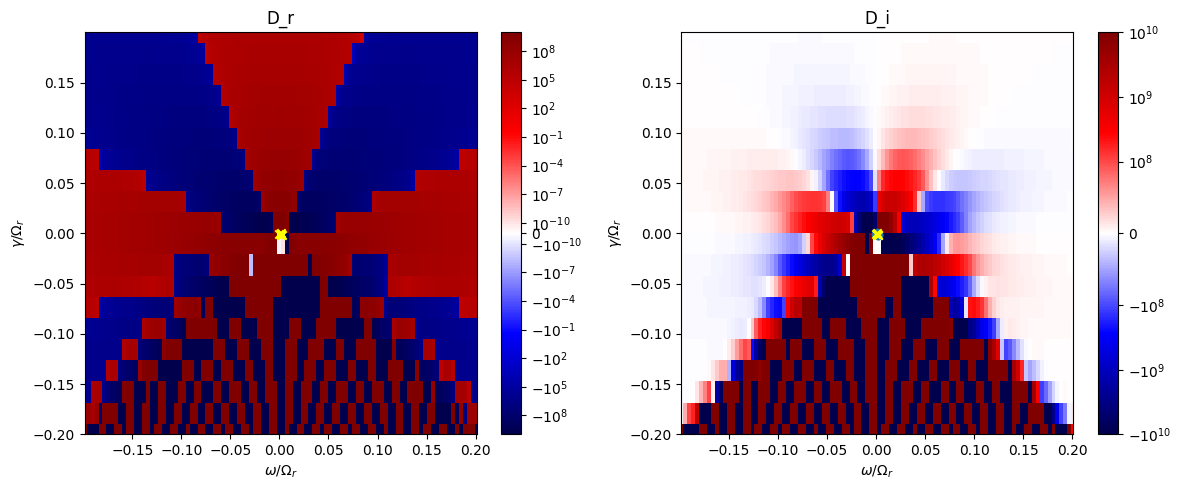

In [134]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

oms = [rt.real for rt in roots]
gams = [rt.imag for rt in roots]
lbls = [_i for _i in range(0,len(oms))]

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# pcolormesh expects 2D meshgrid for coordinates
V1, V2 = np.meshgrid(val1s, val2s)

# symmetric limits
vmax_r = np.nanmax(np.abs(D_r))
vmax_i = np.nanmax(np.abs(D_i))

if(vmax_r > 1e10):
    vmax_r = 1e10
if(vmax_i > 1e10):
    vmax_i = 1e10  
# threshold around zero where it switches from linear to log
linthresh = 1e-10   # <-- adjust this as needed
pcm0 = axes[0].pcolormesh(
    V1, V2, D_r, shading='auto', cmap='seismic',
    norm=colors.SymLogNorm(linthresh=linthresh, vmin=-vmax_r, vmax=vmax_r)
)
fig.colorbar(pcm0, ax=axes[0])
axes[0].set_title("D_r")
axes[0].set_xlabel(r"$\omega/\Omega_r$")
axes[0].set_ylabel(r"$\gamma/\Omega_r$")

linthresh = 1e8   # <-- adjust this as needed
pcm1 = axes[1].pcolormesh(
    V1, V2, D_i, shading='auto', cmap='seismic',
    norm=colors.SymLogNorm(linthresh=linthresh, vmin=-vmax_i, vmax=vmax_i)
)
fig.colorbar(pcm1, ax=axes[1])
axes[1].set_title("D_i")
axes[1].set_xlabel(r"$\omega/\Omega_r$")
axes[1].set_ylabel(r"$\gamma/\Omega_r$")
axes[1].scatter(oms,gams)

for ax in axes:
    ax.set_xlim(val1_min,val1_max)
    ax.set_ylim(val2_min,val2_max)
    ax.scatter(oms,gams,marker='x',color='yellow')

plt.tight_layout()
plt.show()

In [ ]:
#one can just pass any complex number into the fpc solver!